In [20]:
import tensorflow as tf
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.preprocessing import image as Image
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [156]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [157]:
def fetch_image(url,size):
    name=url.split("/")[-1]
    image_path=tf.keras.utils.get_file(name,origin=url)
    image=tf.keras.preprocessing.image.load_img(image_path,target_size=size)
    return image

In [158]:
def normalize_image(image):
    image=255*(image+1.0)/2.0
    return tf.cast(image,tf.uint8)

In [159]:
def show_image(image):
    plt.figure(figsize=(20,20))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

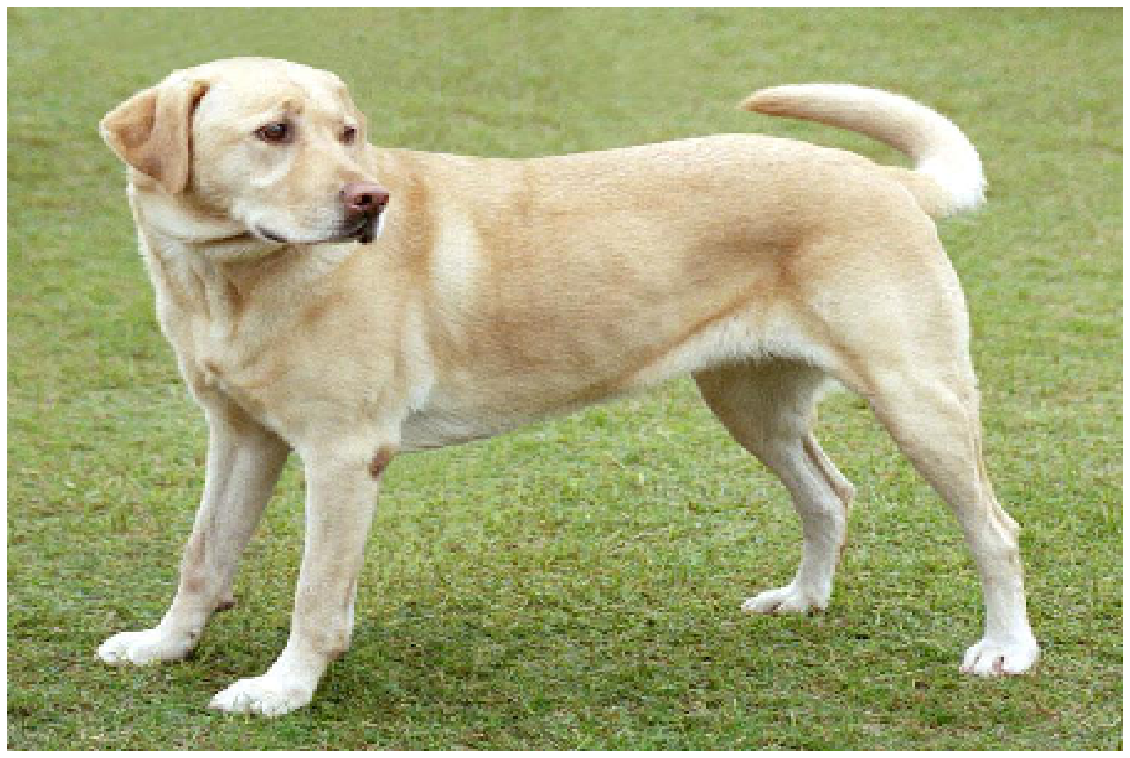

In [184]:
image=fetch_image(url,[300,450])
image=np.array(image)
show_image(image)

In [185]:
base_model=tf.keras.applications.InceptionV3(include_top=False,weights="imagenet")

In [186]:
names=['mixed3','mixed5']
layers=[base_model.get_layer(name).output for name in names]
dream_model=tf.keras.Model(inputs=base_model.input,outputs=layers)

In [187]:
def calculate_loss(image,model):
    image_batch=tf.expand_dims(image,axis=0)
    layer_activations=model(image_batch)
    
    losses=[]
    for activation in layer_activations:
        loss=tf.math.reduce_mean(activation)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [188]:
@tf.function
def deepdream(model,image,step_size):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss=calculate_loss(image,model)
    gradients=tape.gradient(loss,image)
    gradients/=tf.math.reduce_std(gradients)+1e-8
    image=image+gradients*step_size
    image=tf.clip_by_value(image,-1,1)
    return loss,image

In [11]:
def run_model(model,image,steps=100,step_size=0.01):
    image=tf.keras.applications.inception_v3.preprocess_input(image)
    for step in range(steps):
        loss,image=deepdream(model,image,step_size)
        if step%100==0:
            clear_output(wait=True)
            show_image(normalize_image(image))
            print("Step {} Loss {}".format(step,loss))
    result=normalize_image(image)
    clear_output(wait=True)
    show_image(result)
    
    return result

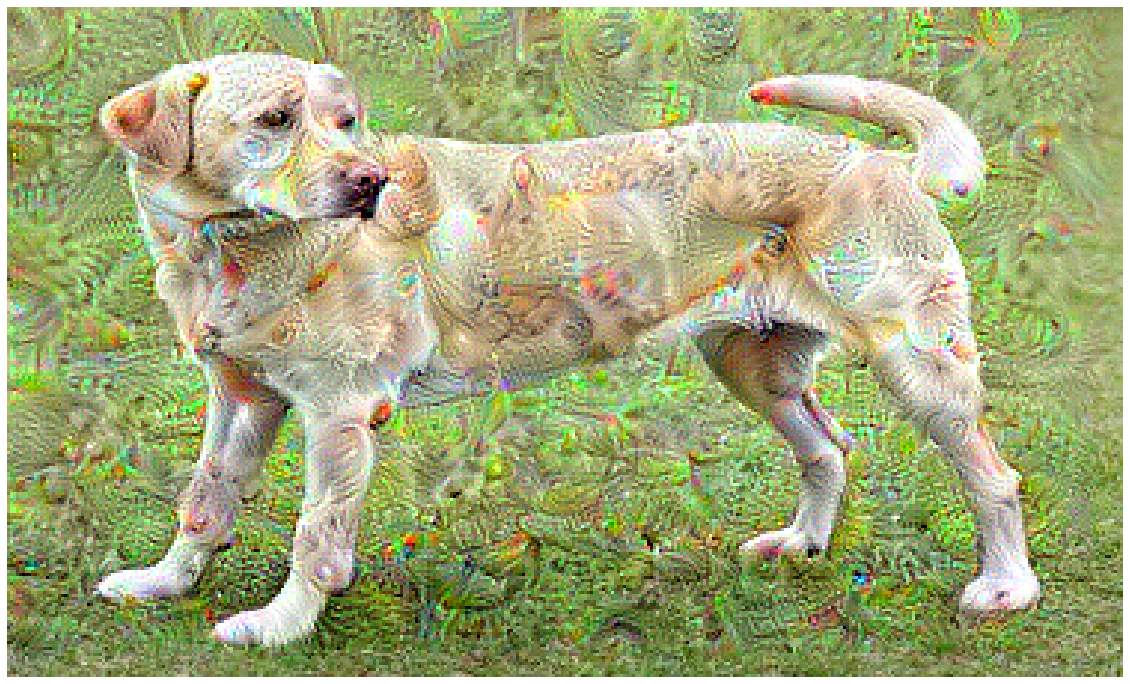

In [30]:
dream_image=run_model(model=dream_model,image=image,steps=1500,step_size=0.001)

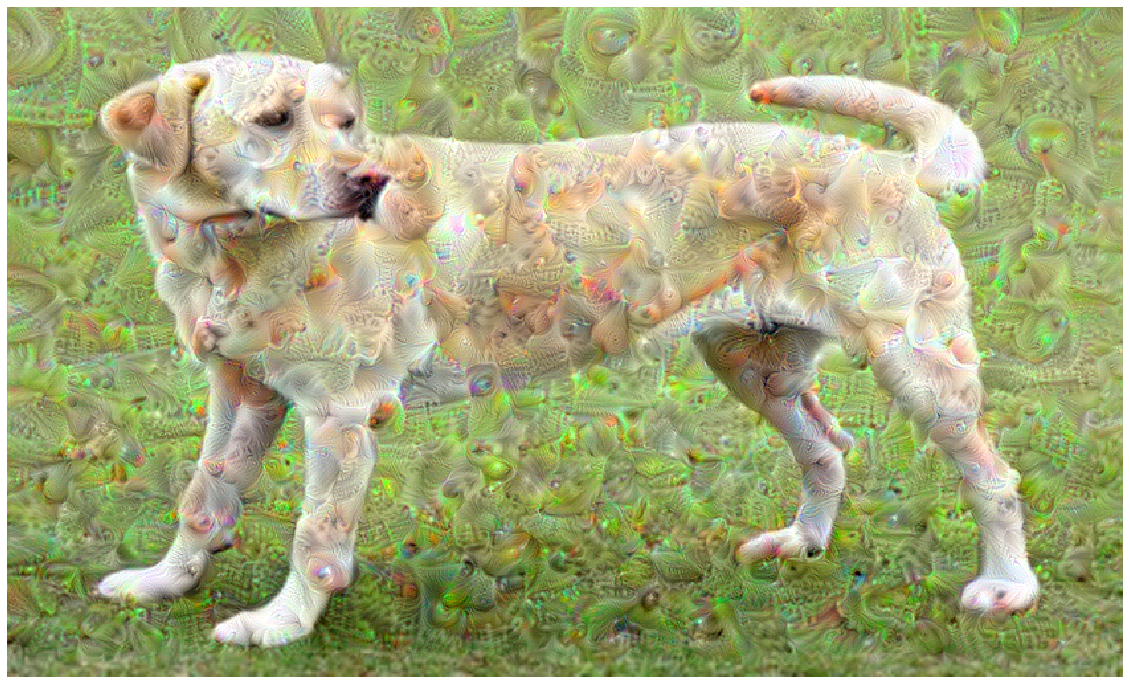

In [12]:
OCTAVE_SCALE=1.5
image=tf.constant(np.array(image))
base_shape=tf.cast(tf.shape(image)[:-1],tf.float32)
for n in range(3):
    new_shape=tf.cast(base_shape*(OCTAVE_SCALE**n),tf.int32)
    image=tf.image.resize(image,new_shape).numpy()
    image=run_model(dream_model,image,steps=400,step_size=0.001)
clear_output(wait=True)
show_image(image)

In [189]:
def random_roll(image,max_roll):
    shift=tf.random.uniform(shape=[2],minval=-max_roll,maxval=max_roll,dtype=tf.int32)
    shift_down,shift_right=shift[0],shift[1]
    rolled_image=tf.roll(tf.roll(image,shift_right,axis=1),shift_down,axis=1)
    return shift_down,shift_right,rolled_image

In [190]:
@tf.function
def tiled_gradients(model,image,tile_size=512):
    shift_down,shift_right,rolled_image=random_roll(image,tile_size)
    gradients=tf.zeros_like(rolled_image)
    for x in range(0,rolled_image.shape[0],tile_size):
        for y in range(0,rolled_image.shape[1],tile_size):
            with tf.GradientTape() as tape:
                tape.watch(rolled_image)
                tile=rolled_image[x:x+tile_size,y:y+tile_size]
                loss=calculate_loss(tile,model)
            gradients=gradients+tape.gradient(loss,rolled_image)
    gradients=tf.roll(tf.roll(gradients,-shift_right,axis=1),-shift_down,axis=1)
    gradients/=tf.math.reduce_std(gradients)+1e-8
    return gradients

In [191]:
def run_deep_dream(model,image,steps_per_octave=100,step_size=0.001,num_octaves=3,octave_scale=1.3):
    image=Image.img_to_array(image)
    image=tf.keras.applications.inception_v3.preprocess_input(image)
    for octave in range(num_octaves):
        new_size=tf.cast(tf.convert_to_tensor(image.shape[:2]),tf.float32)*octave_scale
        image=tf.image.resize(image,tf.cast(new_size,tf.int32))
        for step in range(steps_per_octave):
            gradients=tiled_gradients(model,image)
            image+=gradients*step_size
            image=tf.clip_by_value(image,-1,1)
            if step%10==0:
                clear_output(wait=True)
                show_image(normalize_image(image))
                print('Octave {} Step {}'.format(octave,step))
        clear_output(wait=True)
        result=normalize_image(image)
        show_image(result)
        return result

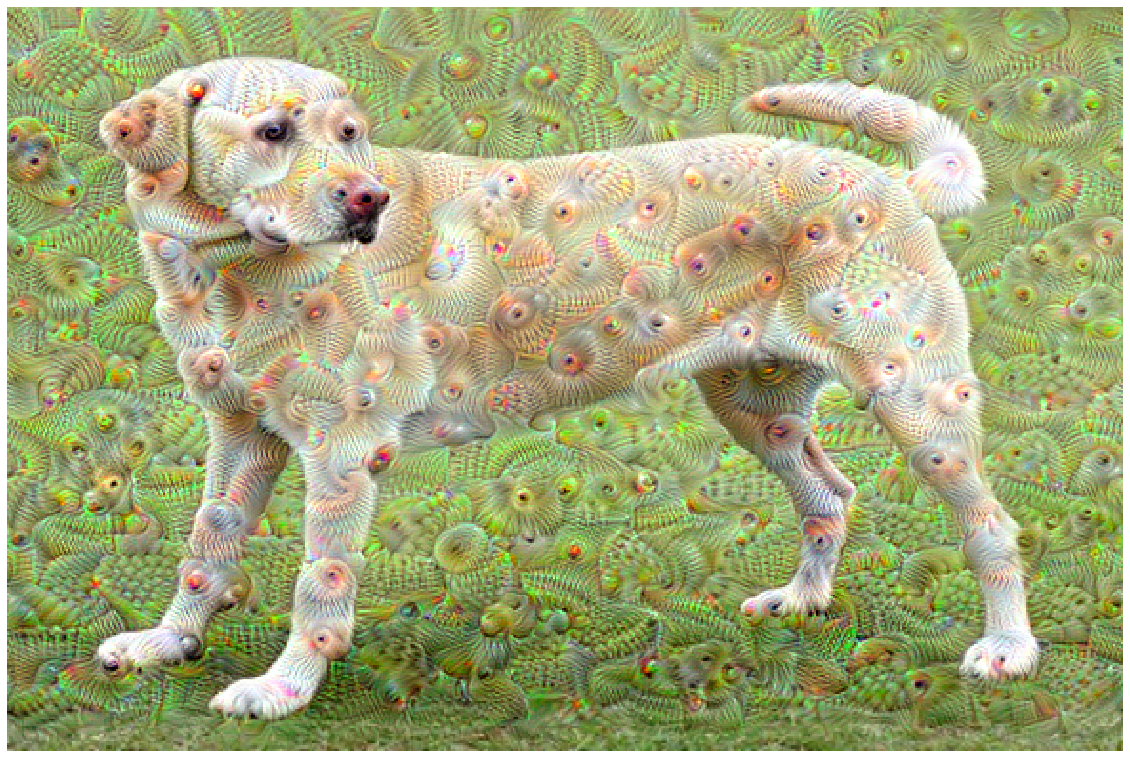

In [192]:
dream_image=run_deep_dream(dream_model,image,steps_per_octave=150,step_size=0.01)
clear_output()
show_image(dream_image)